# Structure learning in decomposable graphical models

## Gaussian graphical models (GGMs)

In [13]:
import numpy as np
import pandas as pd
import trilearn.smc as smc
np.random.seed(1)

Read data from file

In [14]:
df = pd.read_csv("sample_data/dataset_p15.csv", header=None)

In [15]:
df.shape

(100, 15)

In [16]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.268878,0.109906,-0.353295,-1.077679,-0.707938,-3.356246,-1.899697,-1.572408,-1.363449,0.387727,-1.100505,-0.583745,0.582096,0.332725,-1.072969
1,0.717418,0.889198,0.793387,1.966528,0.753154,-0.399547,0.531658,0.207708,0.779332,1.288162,0.215957,0.541811,0.309820,1.210676,0.042214
2,1.064512,1.587411,0.138867,0.363370,0.503868,1.193544,0.182134,-0.597229,0.219855,0.189130,0.921610,-0.414998,0.224087,0.966131,-0.845206


Generate particle Gibbs trajectory of graphs 

In [17]:
graph_traj = smc.gen_pgibbs_ggm_trajectory(dataframe=df, n_particles=50, n_samples=50)

Inspect the likelihood, and the auto-correlation (on graph size) plots to determine the burn-in period

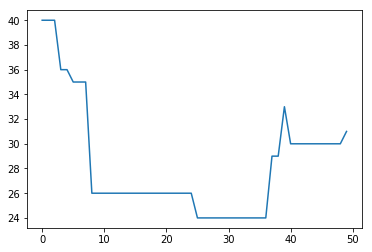

In [19]:
graph_traj.autocorrelation_size().plot()

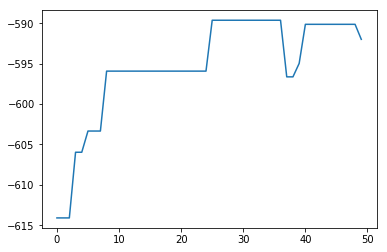

In [20]:
graph_traj.likelihood().plot()

Plot the heatmap based on the samples after the burnin period

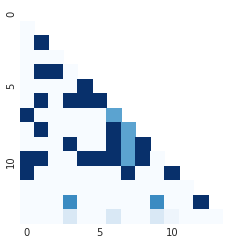

In [22]:
graph_traj.plot_heatmap(from_index=30)

## Discrete log-linear models

Read data from file, where the first two rows, [0, 1], of the file should specify the labels and the levels of the corresponding variables. The outcomes are assumed to be 

In [23]:
df = pd.read_csv("sample_data/czech_autoworkers.csv", header=[0, 1])

In [24]:
df.shape

(1841, 6)

In [25]:
df.head(3)

,A,B,C,D,E,F
,2,2,2,2,2,2
0,1,1,1,0,0,0
1,1,1,1,0,0,0
2,1,1,1,0,0,0


Generate particle Gibbs trajectory of graphs

In [26]:
graph_traj = smc.gen_pgibbs_loglin_trajectory(dataframe=df, n_particles=20, n_samples=50)

Inspect the likelihood and the auto-correlation (on graph size) plots to determine the burn-in period

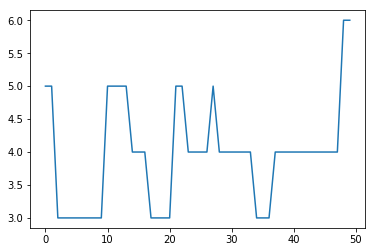

In [13]:
graph_traj.autocorrelation_size().plot()

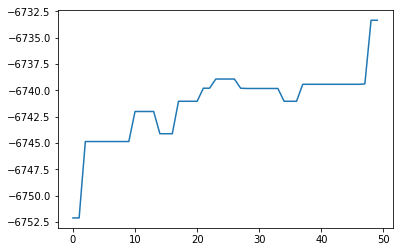

In [14]:
graph_traj.likelihood().plot()

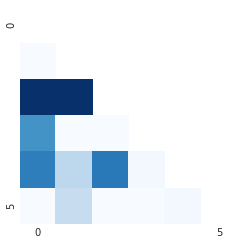

In [27]:
graph_traj.plot_heatmap(from_index=0)

## Simulate junction trees and decomposable graphs

In [28]:
from trilearn.graph import junction_tree as jt

In [29]:
tree = jt.sample_junction_tree(internal_nodes=5)

In [30]:
tree.nodes()

[frozenset({0, 2, 4}), frozenset({1, 2, 4}), frozenset({3, 4})]

In [31]:
tree.edges()

[(frozenset({0, 2, 4}), frozenset({3, 4})),
 (frozenset({0, 2, 4}), frozenset({1, 2, 4}))]

In [32]:
graph = jt.graph(tree)

In [33]:
graph.nodes()

[0, 1, 2, 3, 4]

In [34]:
graph.edges()

[(0, 2), (0, 4), (1, 2), (1, 4), (2, 4), (3, 4)]